# Bayesian A/B Testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [3]:
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

## Simulate purchases with $p_A = 0.05$

In [16]:
p_A = 0.05
N = 1500
obs = tfd.Bernoulli(probs=p_A).sample(sample_shape=N, seed=10)
obs_sum = tf.reduce_sum(obs)
obs_mean = tf.reduce_mean(tf.cast(obs, tf.float32))

[ obs_, obs_sum_, obs_mean_ ] = evaluate([
    obs, obs_sum, obs_mean
])

print('Simulated Purchases: ', obs_)
print('Total #Purchases: ', obs_sum_)
print('Observed Frequency: ', obs_mean_)

Simulated Purchases:  [0 0 0 ... 0 0 0]
Total #Purchases:  88
Observed Frequency:  0.058666665


In [17]:
def joint_log_prob(obs, p_A):
    var_p_A = tfd.Uniform(low=0., high=1.)
    var_obs = tfd.Bernoulli(probs=p_A)
    return (
        var_p_A.log_prob(p_A)
        + tf.reduce_sum(var_obs.log_prob(obs))
    )

## Inference

In [27]:
nsteps = 25000
burn_in = nsteps // 2
initial_chain_state = [
    tf.reduce_mean(tf.cast(obs, tf.float32))
    * tf.ones([], dtype=tf.float32, name='init_p_A')
]
# bijectors
bijectors = [ tfb.Identity() ]

# log-prob
log_prob = lambda *args: joint_log_prob(obs, *args)

# step size
step_size = tf.Variable(0.5, name='step_size', trainable=False)

# hmc kernel
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        step_size=step_size, num_leapfrog_steps=2,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burn_in * 0.8)),
        state_gradients_are_stopped=True),
    bijector=bijectors
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:581: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))


In [28]:
# Sampling from the chain.
[ post_p_A ], kernel_results = tfp.mcmc.sample_chain(
    num_results=nsteps,
    num_burnin_steps=burn_in,
    current_state=initial_chain_state,
    kernel=hmc
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [29]:
[ post_p_A_, kernel_results_ ] = evaluate([
    post_p_A, kernel_results
])

(array([4.000e+00, 9.000e+00, 4.000e+01, 6.700e+01, 1.940e+02, 4.020e+02,
        6.820e+02, 9.550e+02, 1.212e+03, 1.458e+03, 1.583e+03, 1.545e+03,
        1.292e+03, 1.020e+03, 7.270e+02, 5.610e+02, 3.530e+02, 1.810e+02,
        1.400e+02, 4.500e+01, 1.100e+01, 7.000e+00, 9.000e+00, 1.000e+00,
        2.000e+00]),
 array([0.03836779, 0.04029883, 0.04222987, 0.04416091, 0.04609195,
        0.04802299, 0.04995403, 0.05188507, 0.05381611, 0.05574715,
        0.05767819, 0.05960923, 0.06154026, 0.0634713 , 0.06540234,
        0.06733339, 0.06926443, 0.07119546, 0.0731265 , 0.07505754,
        0.07698858, 0.07891962, 0.08085066, 0.0827817 , 0.08471274,
        0.08664378], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f8c1200e898>])

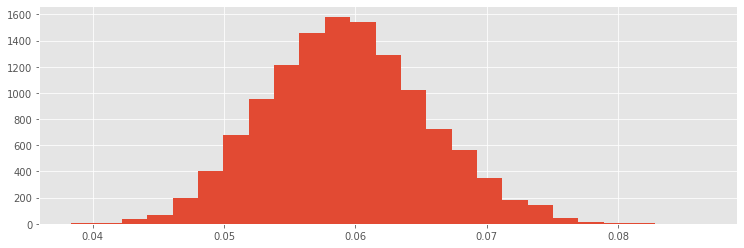

In [30]:
plt.figure(figsize=(12.5, 4))
#plt.vlines(p_A, 0, 90, linestyle='--')
plt.hist(post_p_A_[burn_in:], bins=25, histtype='stepfilled') #, normed=True)

## A and B Together

In [35]:
true_p_A = 0.05
true_p_B = 0.04
N_A = 1500
N_B = 750

obs_A = tfd.Bernoulli(name='obs_A', probs=true_p_A).sample(N_A, seed=645)
obs_B = tfd.Bernoulli(name='obs_B', probs=true_p_B).sample(N_B, seed=645)
[ obs_A_, obs_B_ ] = evaluate([
    obs_A, obs_B
])

print('Observations from Site A: ', obs_A_[:20], '...')
print('Observed p(A): ', obs_A_.mean())
print('Observations from Site B: ', obs_B_[:20], '...')
print('Observed p(B): ', obs_B_.mean())

Observations from Site A:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0] ...
Observed p(A):  0.05733333333333333
Observations from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed p(B):  0.044


In [36]:
def delta(p_A, p_B):
    return p_A - p_B

def join_log_prob_AB(obs_A, obs_B, p_A, p_B):
    var_p_A = tfd.Uniform(low=0., high=1.)
    var_p_B = tfd.Uniform(low=0., high=1.)
    var_obs_A = tfd.Bernoulli(probs=p_A)
    var_obs_B = tfd.Bernoulli(probs=p_B)
    
    return (
        var_p_A.log_prob(p_A)
        + var_p_B.log_prob(p_B)
        + tf.reduce_sum(var_obs_A.log_prob(obs_A))
        + tf.reduce_sum(var_obs_B.log_prob(obs_B))
    )

In [39]:
nsteps = 37200
burn_in = 1000

initial_chain_state = [
    tf.reduce_mean(tf.cast(obs_A, tf.float32))
    * tf.ones([], dtype=tf.float32, name='init_p_A'),
    tf.reduce_mean(tf.cast(obs_B, tf.float32))
    * tf.ones([], dtype=tf.float32, name='init_p_B')
]

bijectors = [ tfb.Identity(), tfb.Identity() ]

log_prob_AB = lambda *args: join_log_prob_AB(obs_A, obs_B, *args)

# step size
step_size = tf.Variable(0.5, name='step_size', trainable=False)

# hmc kernel
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_AB,
        step_size=step_size, num_leapfrog_steps=3,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burn_in * 0.8)),
        state_gradients_are_stopped=True),
    bijector=bijectors
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:581: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))


In [40]:
[ post_p_A, post_p_B ], kernel_results = tfp.mcmc.sample_chain(
    num_results=nsteps, num_burnin_steps=burn_in,
    current_state=initial_chain_state, kernel=hmc
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


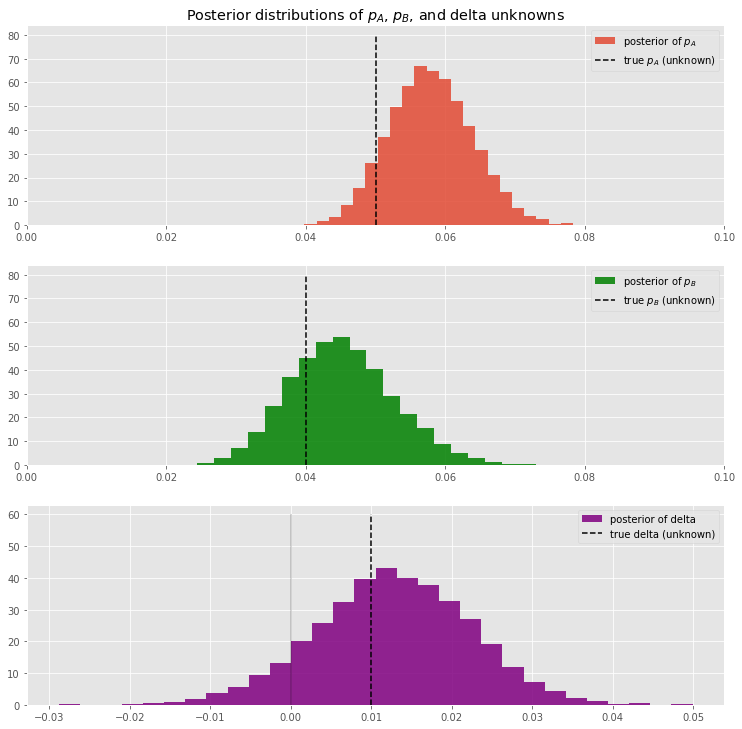

In [49]:
[ post_p_A_, post_p_B_, kernel_results_ ] = evaluate([
    post_p_A, post_p_B, kernel_results 
])


plt.figure(figsize=(12.5, 12.5))

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(post_p_A_[burn_in:], histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)", color='black')
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(post_p_B_[burn_in:], histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color='green', density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)", color='black')
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist((post_p_A_ - post_p_B_)[burn_in:], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color='purple', density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--", color='black',
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");